In [17]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
font = {'family' : 'STIXGeneral',
        'size'   : 15}
matplotlib.rc('font', **font)

from occrx.framestreamer import FrameStreamer
import occrx.templates
import occrx.calibrator
from occscripts.occscriptutils import Circle, Rectangle
from occrx.occParams import OCCSystemParams, OCCTxParams, OCCRxParams, OCCChannelParams
import occscripts
import json

def getDirectory(baseFolder,frequency,distance): 
    sample = '/f{}_s1920.0x1080.0_fps30.0_g75.0_wb6500_exp3.0_distance{}cm'.format(frequency,distance)
    return baseFolder+sample

def detectRoi(frame, template, threshold,method = cv2.TM_CCOEFF_NORMED):
    result = cv2.matchTemplate(frame, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    h, w, z = template.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    roi= np.array((top_left, bottom_right))
    if(max_val >= threshold):
        return True,top_left,bottom_right,max_val,min_loc,min_val,roi
    return False,top_left,bottom_right,max_val,min_loc,min_val,roi

(0, 44)
(0, 89)
(0, 58)
The streamer has been stopped succesfully.
The streamer is going to be stopped


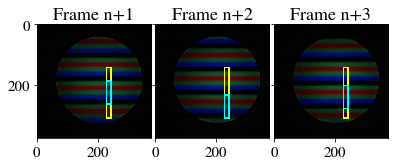

In [18]:
frequency = 2160
distance = 40
baseFolder = getDirectory('../videos/validation',frequency,distance)
videoFile = baseFolder+'/calibration.avi'
circle = Circle()
with open(baseFolder + "/circle.json", "r") as read_file:
    circle.initFromJSON(json.load(read_file))

occSystemParams = occrx.occParams.OCCSystemParams()
with open(baseFolder+ "/occsystemparams.json", "r") as read_file:
    occSystemParams.initFromJSON(json.load(read_file))

streamer = FrameStreamer(videoFile, isRealTime=False)
streamer.start()
isGrabbed, frame = streamer.grabFrame()

roiPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.roiPattern,
                                                      11)
packetPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.roiPattern,
                                                     5)
calibrationPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.roiPattern,
                                                          10)
roiTemplate = occrx.templates.generateTemplate(pattern=roiPattern,
                                                   rowHeight=occSystemParams.occRxParams.rowHeight,
                                                   columnHeight=15)
packetTemplate = occrx.templates.generateTemplate(pattern=packetPattern,
                                                  rowHeight=occSystemParams.occRxParams.rowHeight,
                                                  columnHeight=15)
roiHeight = roiTemplate.shape[0]
calibrationMeasurements = np.zeros((roiHeight, 3, 3))
calibrationFitting = np.zeros((roiHeight,3,3))

height = occSystemParams.occRxParams.rowHeight*11
width = 5
rectangle = Rectangle(topLeftCornerPoint=(0,0),width=width,height=height)

while(isGrabbed):
    isGreater,dtopLeft,dbottom_right,maxVal,minPoint,minVal,droi=detectRoi(frame, roiTemplate, threshold=0)
    rectangle.setTopLeftCornerPoint(dtopLeft)
    isWithinCircle = occscripts.occscriptutils.isRectangleWithinCircle(rectangle,circle)
    
    if(isGreater and isWithinCircle):
        break
    else:
        isGrabbed, frame = streamer.grabFrame()

roiFrame = frame[droi[0][1]:droi[1][1], droi[0][0]:droi[1][0], :].copy()
calibrationMeasurements= occrx.calibrator.resetCalibration(calibrationPattern,
                                                               roiFrame,
                                                               occSystemParams.occRxParams.rowHeight,
                                                               calibrationMeasurements)
fig, ajustAx = plt.subplots(1, 3, figsize=(2.125*3, 0.7*3),sharex=True,sharey=True)
# fig2, ajustAx2 = plt.subplots(1, 4, figsize=(10,5),sharey=True)

isGreater,topLeft,bottom_right,maxVal,minPoint,minVal,roi=detectRoi(roiFrame, packetTemplate, threshold=0)
frameCopy = frame.copy()
cv2.rectangle(frameCopy,dtopLeft,dbottom_right,(1,1,1),3)
cv2.rectangle(frameCopy,(dtopLeft[0],dtopLeft[1]+topLeft[1]),(dtopLeft[0]+15,dtopLeft[1]+topLeft[1]+occSystemParams.occRxParams.rowHeight*5),(0,1,1),3)

count = 0    
ajustAx[0].title.set_text("Frame n+{}".format(count))
ajustAx[0].imshow(frameCopy[320:320+350, 750:750+350]**(1/1.8))

# ajustAx2[0].set_ylim([0,0.40])
# ajustAx2[0].set_xlim([0,100])
# ajustAx2[0].plot(calibrationMeasurements[:,0,1],c='r')
# ajustAx2[0].plot(calibrationMeasurements[:,1,1],c='g')
# ajustAx2[0].plot(calibrationMeasurements[:,2,1],c='b')
for n in range(0,3):
#     for m in range(0,2):
#         if n==0 and m==0:
#             continue
#         else:
            count = count+1
            isGrabbed, frame = streamer.grabFrame()
            roiFrame = frame[droi[0][1]:droi[1][1], droi[0][0]:droi[1][0], :].copy()

            isGreater,topLeft,bottom_right,maxVal,minPoint,minVal,roi=detectRoi(roiFrame, packetTemplate, threshold=0)
            print(topLeft)
        #     calibrationFrame = roiFrame[roi[0][1]:roi[1][1], roi[0][0]:roi[1][0], :].copy()
#             calibrationMeasurements = occrx.calibrator.meassuring(calibrationPattern,
#                                                                   roiFrame,
#                                                                   occSystemParams.occRxParams.rowHeight,
#                                                                   packetTemplate,
#                                                                   calibrationMeasurements)
        #     ajustAx2[m].plot(calibrationMeasurements[:,0,1]**(1/1.88),c='r')
        #     ajustAx2[m].plot(calibrationMeasurements[:,1,1]**(1/1.88),c='g')
        #     ajustAx2[m].plot(calibrationMeasurements[:,2,1]**(1/1.88),c='b')
            frameCopy = frame.copy()
            cv2.rectangle(frameCopy,dtopLeft,dbottom_right,(1,1,0),3)
            cv2.rectangle(frameCopy,(dtopLeft[0],dtopLeft[1]+topLeft[1]),(dtopLeft[0]+15,dtopLeft[1]+topLeft[1]+occSystemParams.occRxParams.rowHeight*5),(0,1,1),3)
            ajustAx[n].title.set_text("Frame n+{}".format(count))
            ajustAx[n].imshow(frameCopy[300:300+375, 750:750+375]**(1/1.8))
    #     plt.show()
# calibrationFitting[:, :, 0] = occrx.calibrator.fitting(calibrationMeasurements[:, :, 0])
# calibrationFitting[:, :, 1] = occrx.calibrator.fitting(calibrationMeasurements[:, :, 1])
# calibrationFitting[:, :, 2] = occrx.calibrator.fitting(calibrationMeasurements[:, :, 2])

plt.subplots_adjust(wspace = 0.0,hspace = 0.3)
# plt.figlegend( lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )
# plt.show()
plt.savefig('./out/calibrationexample4.pdf', bbox_inches='tight')
streamer.stop()